In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

sns.set_style("whitegrid")


In [4]:
# Load the Excel file
file_path = r"D:\arima project\data\obesity+DM+HTN gender final.xlsx"

# Load the specific sheet: "Data final"
df = pd.read_excel(file_path, sheet_name="Data final", engine='openpyxl')

# Show first 5 rows
df.head()


,Sex,Sex Code,Year,Year Code,Deaths,Population,Crude Rate,Crude Rate Lower 95% Confidence Interval,Crude Rate Upper 95% Confidence Interval,Crude Rate Standard Error,Age Adjusted Rate,Age Adjusted Rate Lower 95% Confidence Interval,Age Adjusted Rate Upper 95% Confidence Interval,Age Adjusted Rate Standard Error,% of Total Deaths
0,Female,F,1999,1999,3204,94123092,3.40,3.29,3.52,0.06,3.05,2.94,3.16,0.05,0.0044
1,Female,F,2000,2000,8477,94864102,8.94,8.75,9.13,0.10,7.93,7.76,8.10,0.09,0.0117
2,Female,F,2001,2001,9252,95984408,9.64,9.44,9.84,0.10,8.51,8.34,8.69,0.09,0.0128
3,Female,F,2002,2002,10104,96927703,10.42,10.22,10.63,0.10,9.22,9.03,9.40,0.09,0.0139
4,Female,F,2003,2003,11015,97893297,11.25,11.04,11.46,0.11,9.89,9.70,10.07,0.09,0.0152


In [6]:
print(df.columns.tolist())


['Sex', 'Sex Code', 'Year', 'Year Code', 'Deaths', 'Population', 'Crude Rate', 'Crude Rate Lower 95% Confidence Interval', 'Crude Rate Upper 95% Confidence Interval', 'Crude Rate Standard Error', 'Age Adjusted Rate', 'Age Adjusted Rate Lower 95% Confidence Interval', 'Age Adjusted Rate Upper 95% Confidence Interval', 'Age Adjusted Rate Standard Error', '% of Total Deaths']


In [7]:
# Filter for Female only
female_df = df[df['Sex'] == 'Female']

# Select Year and AAMR column using correct name
female_df = female_df[['Year', 'Age Adjusted Rate']]

# Rename column for simplicity
female_df.columns = ['Year', 'AAMR']

# Set Year as index and convert to datetime
female_df = female_df.set_index('Year')
female_df.index = pd.to_datetime(female_df.index, format='%Y')

# Show cleaned data
female_df.head()


,AAMR
Year,
1999-01-01,3.05
2000-01-01,7.93
2001-01-01,8.51
2002-01-01,9.22
2003-01-01,9.89


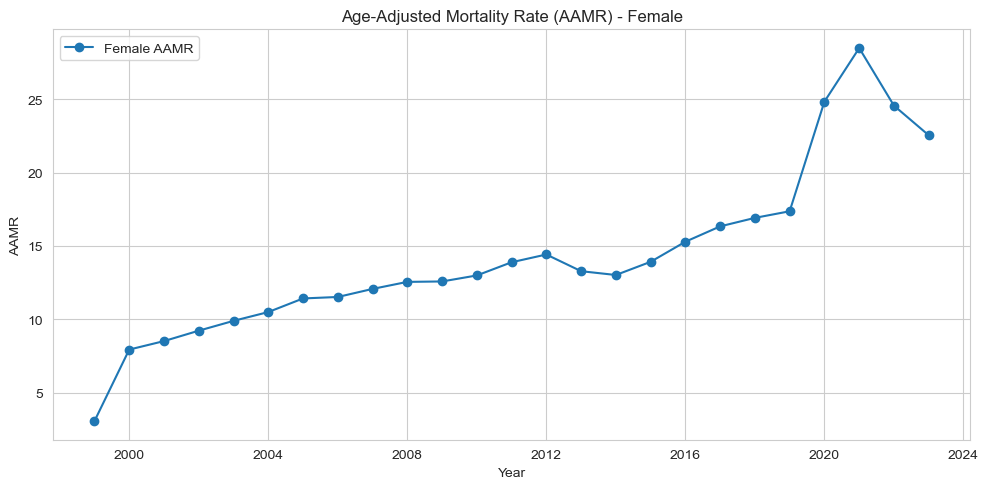

In [8]:
plt.figure(figsize=(10, 5))
plt.plot(female_df.index, female_df['AAMR'], marker='o', label='Female AAMR')
plt.title("Age-Adjusted Mortality Rate (AAMR) - Female")
plt.xlabel("Year")
plt.ylabel("AAMR")
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
# Augmented Dickey-Fuller test
result = adfuller(female_df['AAMR'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value}")
    
# Interpretation
if result[1] < 0.05:
    print("\n✅ The data is stationary (p < 0.05). No differencing needed.")
else:
    print("\n❌ The data is NOT stationary (p ≥ 0.05). Differencing is needed.")


ADF Statistic: 0.3239117227536729
p-value: 0.9784153338295656
Critical Value (1%): -3.889265672705068
Critical Value (5%): -3.0543579727254224
Critical Value (10%): -2.66698384083045

❌ The data is NOT stationary (p ≥ 0.05). Differencing is needed.


In [10]:
# Fit ARIMA using auto_arima (it will handle differencing automatically)
model = auto_arima(
    female_df['AAMR'],
    seasonal=False,         # No seasonality in yearly data
    stepwise=True,          # Fast automatic selection
    suppress_warnings=True, 
    trace=True              # Show model selection process
)

# Show model summary
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=106.224, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=107.947, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=108.985, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=104.845, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=109.269, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=106.220, Time=0.13 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=104.527, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=106.411, Time=0.04 sec

Best model:  ARIMA(0,1,2)(0,0,0)[0] intercept
Total fit time: 1.372 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:             

In [11]:
# Forecast 5 future values
n_years = 5
forecast, conf_int = model.predict(n_periods=n_years, return_conf_int=True)

# Create future years range
last_year = female_df.index.year.max()
future_years = pd.date_range(start=f"{last_year+1}", periods=n_years, freq='Y')

# Build forecast DataFrame
forecast_df = pd.DataFrame({
    'Year': future_years,
    'Forecasted AAMR': forecast,
    'Lower CI': conf_int[:, 0],
    'Upper CI': conf_int[:, 1]
})
forecast_df.set_index('Year', inplace=True)

# Combine actual and forecast for plotting
full_df = pd.concat([female_df, forecast_df], axis=0)


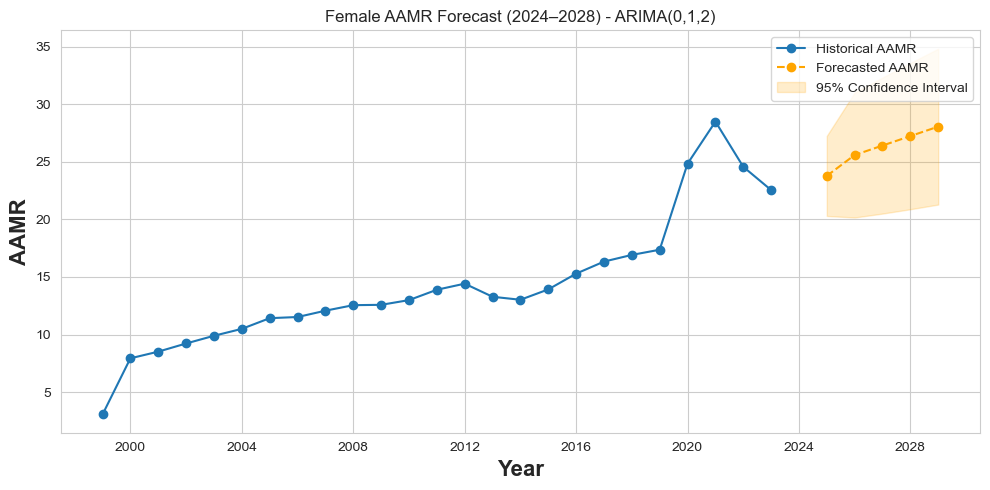

In [16]:
plt.figure(figsize=(10, 5))

# Plot historical
plt.plot(female_df.index, female_df['AAMR'], marker='o', label='Historical AAMR')

# Plot forecast
plt.plot(forecast_df.index, forecast_df['Forecasted AAMR'], marker='o', linestyle='--', color='orange', label='Forecasted AAMR')

# Confidence Interval
plt.fill_between(
    forecast_df.index,
    forecast_df['Lower CI'],
    forecast_df['Upper CI'],
    color='orange',
    alpha=0.2,
    label='95% Confidence Interval'
)

plt.title("Female AAMR Forecast (2024–2028) - ARIMA(0,1,2)")
plt.xlabel("Year", fontsize = 16, fontweight = 'bold')
plt.ylabel("AAMR", fontsize = 16, fontweight = 'bold')
plt.legend()
plt.tight_layout()
plt.show()


In [17]:
# Reset index for saving
forecast_export = forecast_df.copy()
forecast_export.reset_index(inplace=True)

# Save to Excel
output_filename = "female_aamr_forecast_2024_2028.xlsx"
forecast_export.to_excel(output_filename, index=False)

print(f"✅ Forecast saved as: {output_filename}")


✅ Forecast saved as: female_aamr_forecast_2024_2028.xlsx


In [18]:
# Filter for Male
male_df = df[df['Sex'] == 'Male'][['Year', 'Age Adjusted Rate']]
male_df.columns = ['Year', 'AAMR']
male_df = male_df.set_index('Year')
male_df.index = pd.to_datetime(male_df.index, format='%Y')

# Preview
male_df.head()


,AAMR
Year,
1999-01-01,3.07
2000-01-01,8.52
2001-01-01,9.38
2002-01-01,10.73
2003-01-01,11.57


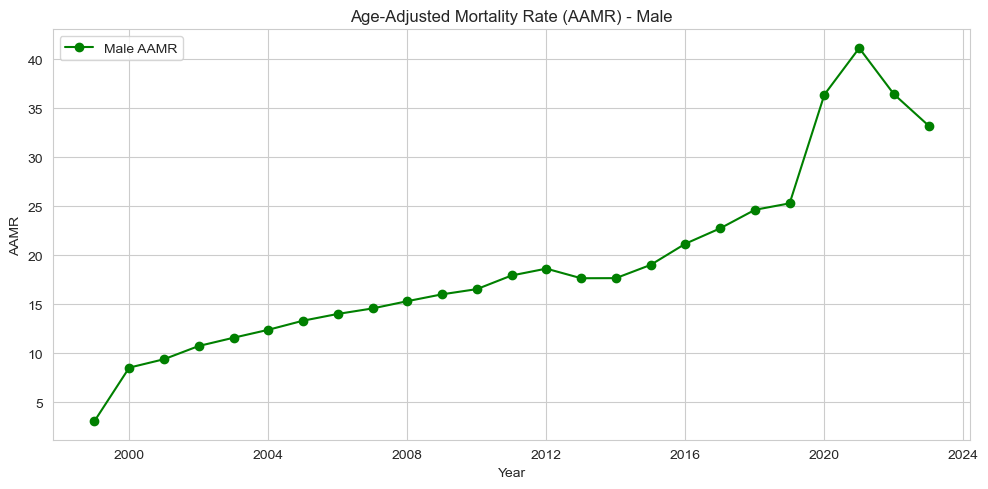

In [19]:
plt.figure(figsize=(10, 5))
plt.plot(male_df.index, male_df['AAMR'], marker='o', label='Male AAMR', color='green')
plt.title("Age-Adjusted Mortality Rate (AAMR) - Male")
plt.xlabel("Year")
plt.ylabel("AAMR")
plt.legend()
plt.tight_layout()
plt.show()


In [20]:
result_male = adfuller(male_df['AAMR'])

print("ADF Statistic:", result_male[0])
print("p-value:", result_male[1])
for key, value in result_male[4].items():
    print(f"Critical Value ({key}): {value}")

if result_male[1] < 0.05:
    print("\n✅ The Male data is stationary (p < 0.05).")
else:
    print("\n❌ The Male data is NOT stationary. Differencing needed.")


ADF Statistic: 1.3064001992917589
p-value: 0.9966445317512268
Critical Value (1%): -3.9644434814814815
Critical Value (5%): -3.0849081481481484
Critical Value (10%): -2.6818144444444445

❌ The Male data is NOT stationary. Differencing needed.


In [21]:
model_male = auto_arima(
    male_df['AAMR'],
    seasonal=False,
    stepwise=True,
    suppress_warnings=True,
    trace=True
)
print(model_male.summary())


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=123.099, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=122.160, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=123.009, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=120.857, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=124.452, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=122.448, Time=0.04 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=121.307, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=121.340, Time=0.02 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.502 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   25
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -57.429
Date:                Sun, 03 Aug 2025   AIC                   

In [22]:
# Forecast 5 years ahead
forecast_male, conf_int_male = model_male.predict(n_periods=5, return_conf_int=True)

# Future years
last_year_male = male_df.index.year.max()
future_years_male = pd.date_range(start=f"{last_year_male+1}", periods=5, freq='Y')

# Build forecast DataFrame
forecast_df_male = pd.DataFrame({
    'Year': future_years_male,
    'Forecasted AAMR': forecast_male,
    'Lower CI': conf_int_male[:, 0],
    'Upper CI': conf_int_male[:, 1]
})
forecast_df_male.set_index('Year', inplace=True)


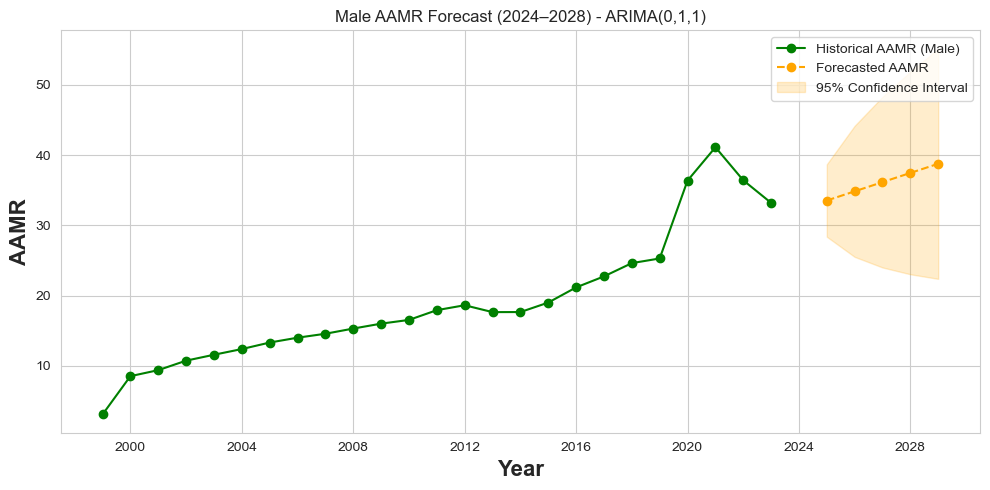

In [24]:
plt.figure(figsize=(10, 5))

# Historical
plt.plot(male_df.index, male_df['AAMR'], marker='o', label='Historical AAMR (Male)', color='green')

# Forecast
plt.plot(forecast_df_male.index, forecast_df_male['Forecasted AAMR'], marker='o', linestyle='--', color='orange', label='Forecasted AAMR')

# Confidence Interval
plt.fill_between(
    forecast_df_male.index,
    forecast_df_male['Lower CI'],
    forecast_df_male['Upper CI'],
    color='orange',
    alpha=0.2,
    label='95% Confidence Interval'
)

plt.title("Male AAMR Forecast (2024–2028) - ARIMA(0,1,1)")
plt.xlabel("Year", fontsize = 16, fontweight = 'bold')
plt.ylabel("AAMR", fontsize = 16, fontweight = 'bold')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()
